# Comparison of a simulated and a real trace of HPL

In [1]:
import io
import os
import zipfile
import pandas
import yaml
from plotnine import *
import plotnine
import sys
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

In [2]:
reality_archive = 'geometry/8/grenoble_2020-08-05_1943292.zip'
simgrid_archives = ['../smpi_hpl/geometry/20/grenoble_2020-08-05_1943291.zip']
sizes = list(read_csv(reality_archive, 'results.csv').matrix_size)
for archive in simgrid_archives:
    assert sizes == list(read_csv(archive, 'results.csv').matrix_size)
print(sizes)

[100000]


In [3]:
def filter_pajeng(pajeng_output, keep):
    lines = pajeng_output.split(b'\n')
    lines = [l for l in lines if l.startswith(keep.encode())]
    return b'\n'.join(lines)

def _read_paje_state(archive_name, csv_name, has_msg_size=False, replace_func=('MPI', 'MPI')):
    columns=['type', 'rank', 'container', 'start', 'end', 'duration', 'level', 'function']
    if has_msg_size:
        columns.append('tmp')
    df = read_csv(archive_name, csv_name, columns=columns, filter_func=lambda x: filter_pajeng(x, 'State'))
    df['function'] = df['function'].str.replace(*replace_func).str.strip()  # for some reason Simgrid uses PMPI_Wait and not MPI_Wait
    df['msg_size'] = -1
    if has_msg_size:
        df.loc[df['function'].isin(['MPI_Recv', 'MPI_Send', 'MPI_Isend', 'MPI_Irecv']), 'msg_size'] = df['tmp']
        df['msg_size'] = df['msg_size'].astype(int)
    df['rank'] = df['rank'].str.slice(5).astype(int)  # changing 'rank42' into 42
    return df

def read_mpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True)
    return df

def read_smpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True, ('PMPI', 'MPI'))
    df['rank'] = -df['rank']  # in SMPI, we have 'rank-42' and not 'rank42', so there remains a - that we should remove
    return df

def read_smpi_link(archive_name, csv_name):
    df = read_csv(archive_name, csv_name,
                  columns=['type', 'level', 'container', 'start', 'end', 'duration', 'commType', 'src', 'dst', 'msg_size'],
                  filter_func=lambda x: filter_pajeng(x, 'Link'))
    df['src'] = df['src'].str.slice(6).astype(int)  # changing 'rank42' into 42
    df['dst'] = df['dst'].str.slice(6).astype(int)  # changing 'rank42' into 42
#    df['remote'] = (df['src'] // 32) != (df['dst'] // 32)
    return df

def read_archive(archive_name, mode, exp_id, drop_func=['MPI_Comm_rank', 'MPI_Comm_size', 'MPI_Comm_split', 'MPI_Comm_free', 'MPI_Init', 'MPI_Finalize']):
    assert mode in ('reality', 'simgrid')
    print('# Mode: %s' % mode)
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
    blas_trace = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    old_len = len(blas_trace)
   # blas_trace = blas_trace[(blas_trace['m'] != 0) & (blas_trace['n'] != 0) & (blas_trace['k'] != 0)]
    print('\tBLAS trace: %6d lines (removed %d lines with null sizes)' % (len(blas_trace), old_len - len(blas_trace)))
    blas_trace['start'] = blas_trace.timestamp
    blas_trace['end'] = blas_trace.timestamp + blas_trace.duration
#    blas_trace = blas_trace[['function', 'start', 'end', 'rank', 'm', 'n', 'k']]
    blas_trace['msg_size'] = -1
    blas_trace['kind'] = 'BLAS'
    if mode == 'reality':
        mpi_trace = read_mpi_state(archive_name, 'trace_mpi_%d.csv' % exp_id)
    else:
        mpi_trace = read_smpi_state(archive_name, 'trace_mpi_%d.csv' % exp_id)
    print('\tMPI  trace: %6d lines' % len(mpi_trace))
    mpi_trace = mpi_trace[['function', 'start', 'end', 'rank', 'msg_size']]
    mpi_trace['kind'] = 'MPI'
    df = pandas.concat([blas_trace, mpi_trace])
    df['mode'] = mode
    df['rank+1'] = df['rank'] + 1
    old_len = len(df)
    df = df[~df['function'].str.strip().isin(drop_func)]
    print('Removed %d events with functions in %s' % (old_len-len(df), ', '.join(drop_func)))
    df['duration'] = df['end'] - df['start']
    df['function'] = df['function'].str.strip()
    return df

traces = None
nbrow_limit = 2000000
for i, size in enumerate(sizes):
    print('Exp %d (matrix_size=%d)' % (i, size))
    for filename, mode in [(reality_archive, 'reality')] + [(archive, 'simgrid') for archive in simgrid_archives]:
        tmp_trace = read_archive(filename, mode, i)
        tmp_trace['matrix_size'] = size
#        if len(tmp_trace) > nbrow_limit:
#            sys.stderr.write('WARNING: dataframe for exp %d (matrix_size=%d) has %d rows, keeping %d' % (i, size, len(tmp_trace), nbrow_limit))
#        tmp_trace = tmp_trace.head(n=nbrow_limit)
        if traces is not None:
            traces = pandas.concat([traces, tmp_trace])
        else:
            traces = tmp_trace

traces.head()

Exp 0 (matrix_size=100000)
# Mode: reality
	BLAS trace: 791584 lines (removed 0 lines with null sizes)
	MPI  trace:   9636 lines
Removed 4166 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode: simgrid
	BLAS trace:  21888 lines (removed 0 lines with null sizes)
	MPI  trace:   4086 lines
Removed 128 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize


,duration,end,file,function,k,kind,line,m,msg_size,n,rank,start,timestamp,mode,rank+1,matrix_size
0,0.000000,4.060801,../HPL_pdtest.c,smpi_marker,NaN,BLAS,202.0,NaN,-1,NaN,0,4.060801,4.060801,reality,1,100000
1,0.000090,4.060938,../HPL_dlocmax.c,idamax,NaN,BLAS,125.0,100000.0,-1,NaN,0,4.060848,4.060848,reality,1,100000
2,0.000008,4.060949,../HPL_pdmxswp.c,dcopy,NaN,BLAS,165.0,128.0,-1,NaN,0,4.060941,4.060941,reality,1,100000
3,0.000003,4.060954,../HPL_pdmxswp.c,dcopy,NaN,BLAS,167.0,128.0,-1,NaN,0,4.060951,4.060951,reality,1,100000
4,0.000057,4.061016,../HPL_pdpancrT.c,dscal,NaN,BLAS,214.0,99999.0,-1,NaN,0,4.060959,4.060959,reality,1,100000


## HPL result

In [4]:
res = read_csv(reality_archive, 'results.csv')
res[['matrix_size', 'time']].sort_values(by='matrix_size')

,matrix_size,time
0,100000,11.77


In [5]:
res = []
for archive in simgrid_archives:
    tmp = read_csv(archive, 'results.csv')
    res.append(tmp)
res = pandas.concat(res)
res[['matrix_size', 'time']].sort_values(by='matrix_size')

,matrix_size,time
0,100000,8.99


## Checking the parameters

In [6]:
parameters = read_csv(simgrid_archives[0], 'exp_hpl.csv')
for archive in simgrid_archives:
    assert read_csv(archive, 'exp_hpl.csv').equals(parameters)
parameters

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,100000,128,1,64,1,2,2,1,0,8,32,1


In [7]:
read_csv(reality_archive, 'exp_hpl.csv')

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,100000,128,1,64,1,2,2,1,0,8,32,1


In [8]:
platforms = set([zipfile.ZipFile(archive).read('dahu_fast_iprobe.xml').decode('ascii') for archive in simgrid_archives])
assert len(platforms) == 1
print(platforms.pop())

<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.965491847282898e-07:9.63619592297199e-11;8133:4.117386759387727e-06:9.998650637323814e-11;15831:3.901910334928982e-06:1.1003492469181915e-10;33956:8.556208528368661e-06:1.2636592924112397e-10;64000:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375236e-06:8.456019002037162e-11;8133:1.0616877366305338e-06:1.0399801951417905e-10;15831:1.1989168715510673e-06:9.880880432093221e-11;33956:1.3028804423006338e-06:1.0742263180618875e-10;64000:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.931229521083401e-07:7.051204536228214e-11;8133:3.601990790153244e-07:1.2449128895712037e-10;15831:2.97701688103096e-06:4.1302612649640425e-11;33956:3.133466154066955e-06:3.293458765281899e-11;64000:6.939993663604069e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4955575510466301;8133:5.649491428460

In [9]:
from IPython.display import display, Markdown
for archive in simgrid_archives:
    installfile = get_yaml(archive, 'info.yaml')['installfile']
    installfile_content = zipfile.ZipFile(archive).read(installfile).decode()
    display(Markdown('Archive name: %s' % archive))
    display(Markdown('```yaml\n%s\n```' % installfile_content))

/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Archive name: ../smpi_hpl/geometry/20/grenoble_2020-08-05_1943291.zip

```yaml
trace_execution: True
terminate_early: True
insert_bcast: True
stochastic_network: True
stochastic_cpu: True
disable_hpl_kernels: False
disable_nondgemm_randomness: False
random_seed: 105

```

In [10]:
non_null_traces = traces[(traces['m'] != 0) & (traces['n'] != 0) & (traces['k'] != 0)].copy()
print(len(non_null_traces), len(traces))
non_null_traces['func'] = non_null_traces['function']
non_null_traces.loc[~non_null_traces['function'].isin(['dgemm', 'dtrsm', 'MPI_Send', 'MPI_Recv']), 'func'] = 'other'

45261 822900


## Visualizing the trace (non-null sizes)

In [11]:
def plot(df, wrap=None, lines=[], hard_lines=False):
    gc = ggplot(df) + geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='func')) + theme_bw()
    if wrap:
        gc = gc + facet_wrap(wrap, labeller='label_both', ncol=2)
        guide = False
    else:
        guide = 'legend'
    gc = gc + scale_fill_brewer(type='qualitative', palette='Dark2', guide=guide)
    if lines:
        gc = gc + scale_x_continuous(breaks = lines) + expand_limits(x=max(lines))
        if hard_lines:
            for line in lines:
                gc = gc + geom_vline(xintercept=line, linetype='dashed', alpha=0.5)
    return gc

def plot_bounded(df, start, end, ranks, wrap=['mode', 'kind']):
    df = df[df['rank'].isin(ranks)]
    df = df[(df['end'] >= start) & (df['start'] <= end)].copy()
    df.loc[df['start'] < start, 'start'] = start
    df.loc[df['end'] > end, 'end'] = end
    return plot(df, wrap) + xlim(start, end) + ggtitle('Events between %.1fs and %.1fs for ranks in %s' % (start, end, ranks))

def my_range(start, stop, nb_steps):
    interval = (stop-start)/(nb_steps+1)
    val = start
    result = []
    for _ in range(nb_steps+2):
        result.append(val)
        val += interval
    return result

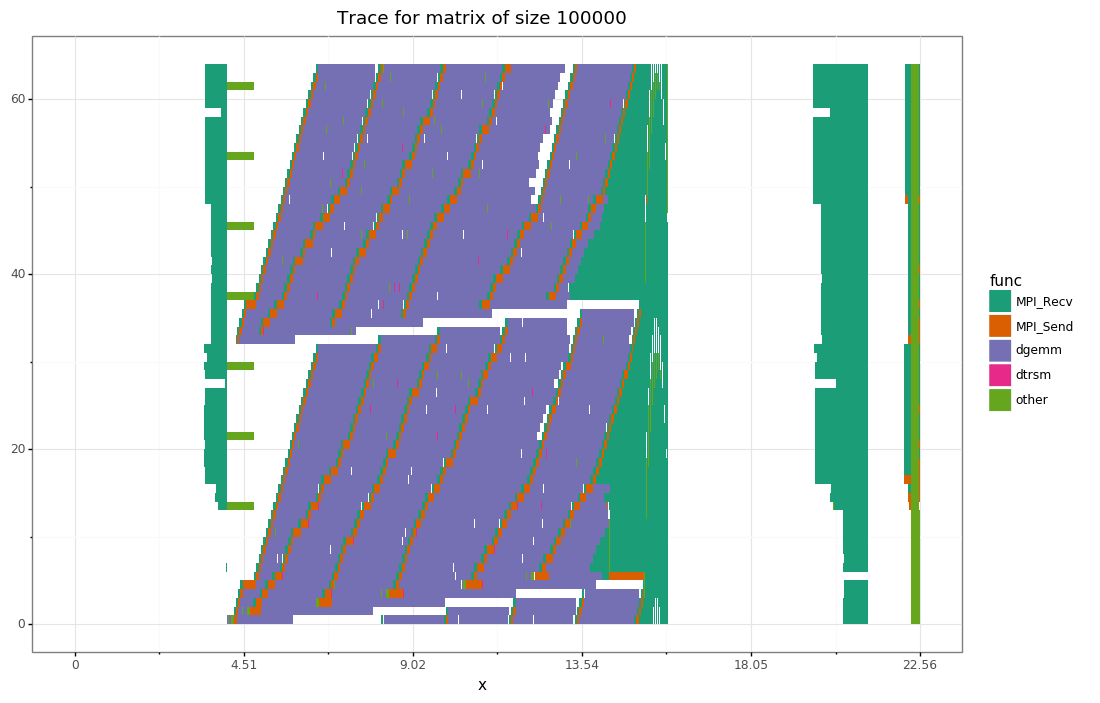

<ggplot: (-9223363274571046919)>


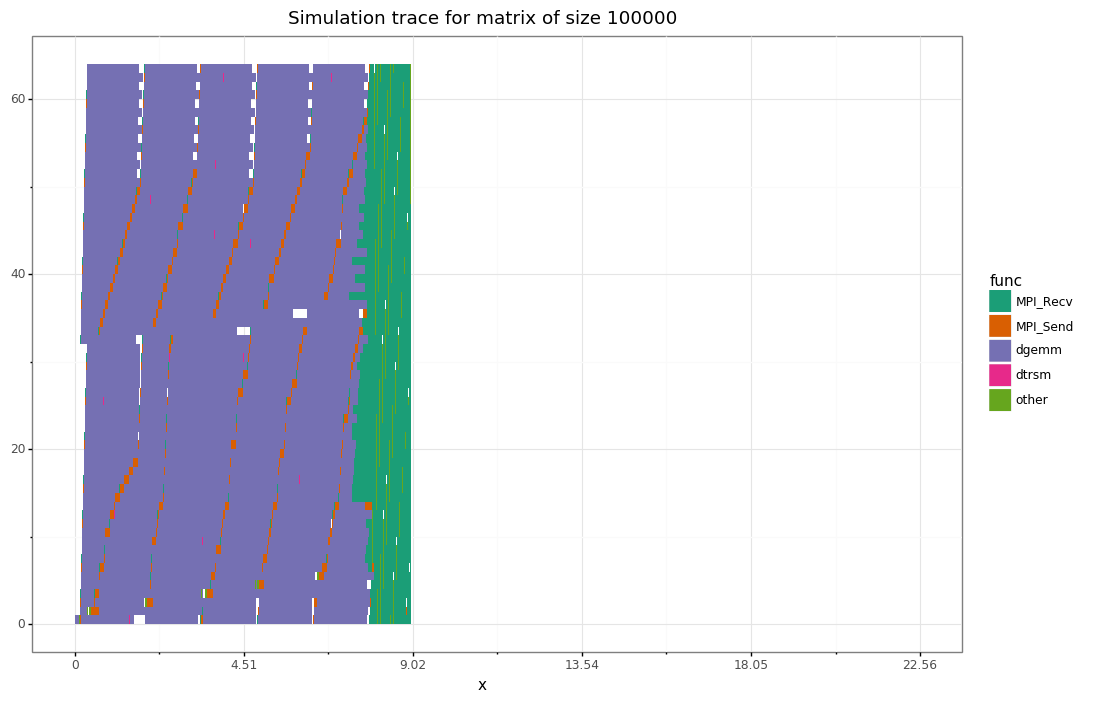

<ggplot: (8762283553814)>


In [12]:
for size in sorted(non_null_traces.matrix_size.unique()):
    tmp = non_null_traces[(non_null_traces['matrix_size'] == size)]
    lines = my_range(non_null_traces.start.min(), non_null_traces.start.max(), 4)
    print(plot(tmp[tmp['mode'] == 'reality'], lines=lines) + ggtitle('Trace for matrix of size %d' % size))
    print(plot(tmp[tmp['mode'] != 'reality'], lines=lines) + ggtitle('Simulation trace for matrix of size %d' % size))

In [13]:
min_croped = non_null_traces[(non_null_traces['mode'] == 'reality') & (non_null_traces['function'] == 'smpi_marker')].timestamp.min()
max_croped = non_null_traces[(non_null_traces['mode'] == 'reality') & (non_null_traces['function'] == 'smpi_marker')].timestamp.max()
tmp_simg = non_null_traces[(non_null_traces['mode'] == 'simgrid')]
tmp_real = non_null_traces[(non_null_traces['mode'] == 'reality') & (non_null_traces['start'] > min_croped) & (non_null_traces['end'] < max_croped)].copy()
tmp_real['start'] -= min_croped
tmp_real['end'] -= min_croped
non_null_traces_croped = pandas.concat([tmp_real, tmp_simg])

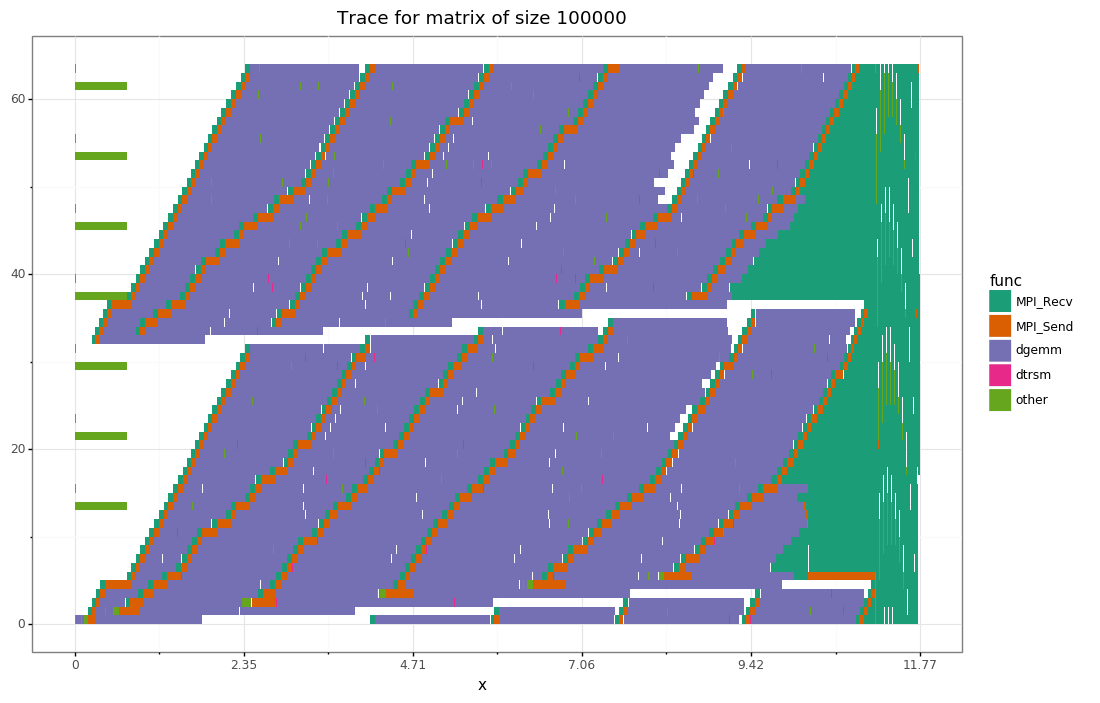

<ggplot: (8762283545839)>


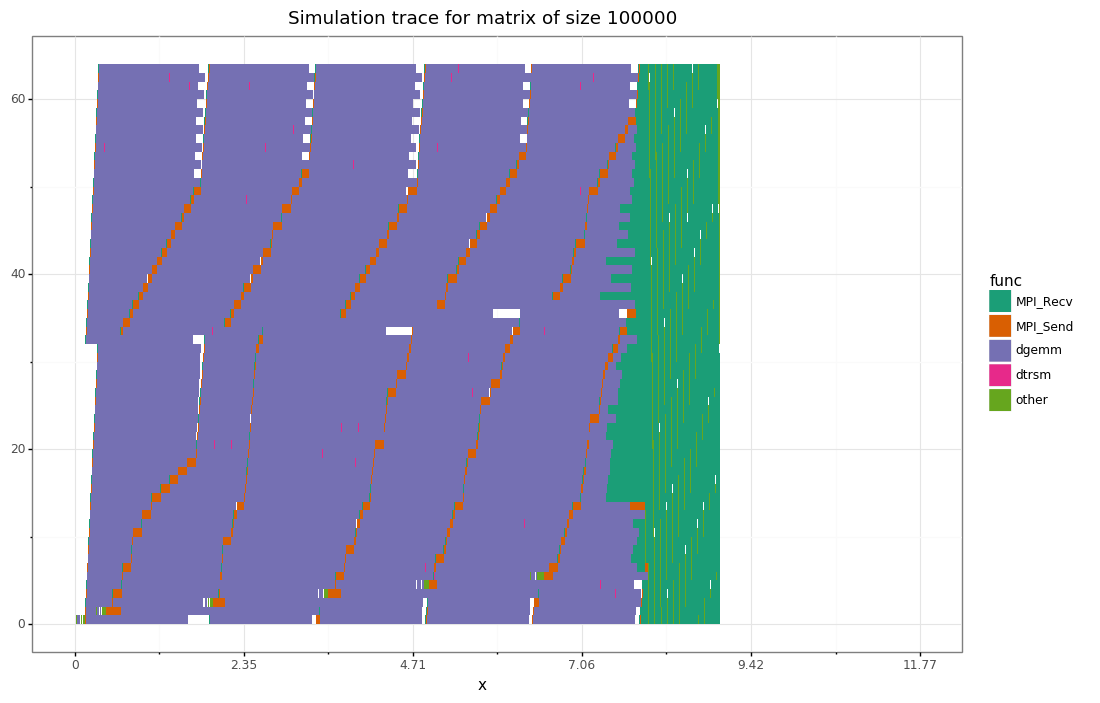

<ggplot: (-9223363274571217927)>


In [14]:
for size in sorted(non_null_traces_croped.matrix_size.unique()):
    tmp = non_null_traces_croped[(non_null_traces_croped['matrix_size'] == size)]
    lines = my_range(non_null_traces_croped.start.min(), non_null_traces_croped.start.max(), 4)
    print(plot(tmp[tmp['mode'] == 'reality'], lines=lines) + ggtitle('Trace for matrix of size %d' % size))
    print(plot(tmp[tmp['mode'] != 'reality'], lines=lines) + ggtitle('Simulation trace for matrix of size %d' % size))

## Null sizes

In [15]:
null_traces = traces[(traces['kind'] == 'BLAS') & ((traces['m'] == 0) | (traces['n'] == 0) | (traces['k'] == 0))]
null_traces.groupby(['mode', 'function'])[['duration']].agg(['sum', 'count'])

duration        
                                sum   count
mode    function                           
reality dgemm          2.347858e-02  386772
        dtrsm          2.195576e-02  386772
simgrid HPL_dlaswp00N  1.101000e-05    1101
        HPL_dlatcpy    3.600000e-07      36
        dgemm          5.510716e+00    1479
        dtrsm          1.479000e-05    1479

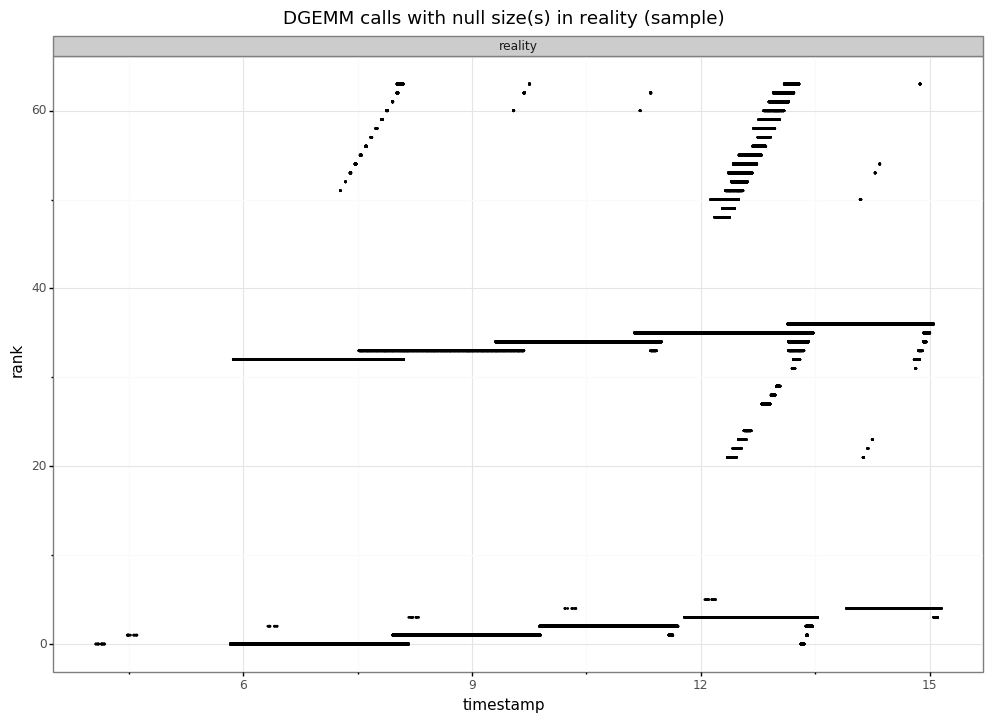

<ggplot: (-9223363274571843054)>


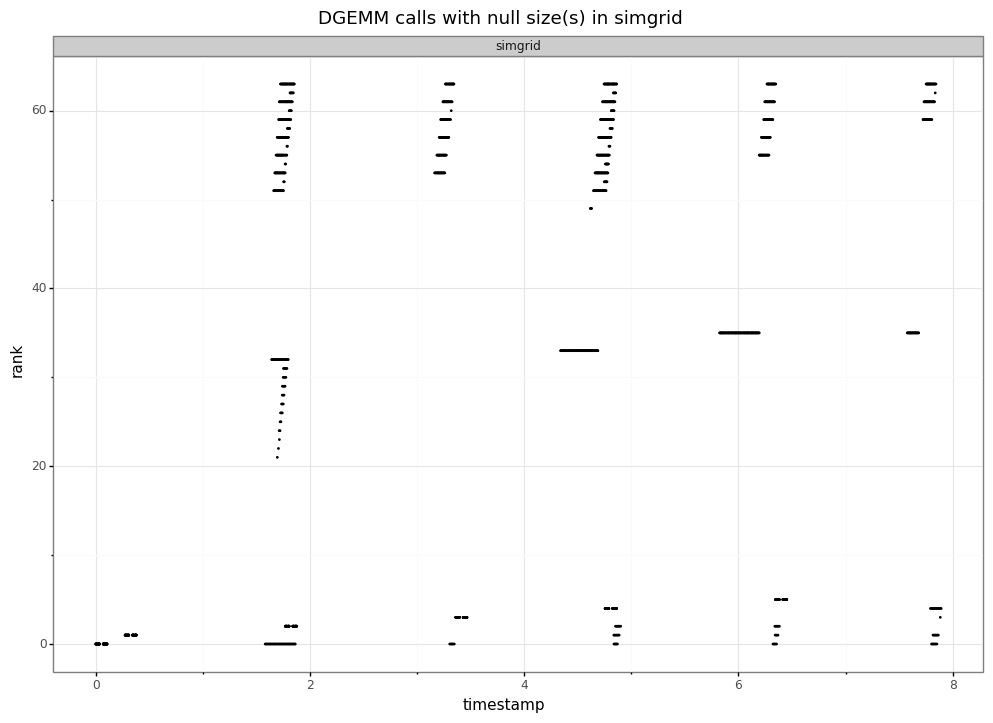

<ggplot: (-9223363274586978083)>


In [16]:
for mode in null_traces['mode'].unique():
    tmp = null_traces[(null_traces['mode'] == mode) & (null_traces['function'] == 'dgemm')]
    try:
        tmp = tmp.sample(n=100000)
        sampled = True
    except ValueError:
        sampled = False
    print(ggplot(tmp)
        + aes(x='timestamp', y='rank')
        + geom_point(size=0.1)
        + facet_wrap('mode')
        + theme_bw()
        + ggtitle(f'DGEMM calls with null size(s) in {mode} {"(sample)" if sampled else ""}')
    )

In [17]:
null_dgemm = null_traces[null_traces['function'] == 'dgemm']
tmp = null_dgemm.groupby(['file', 'line', 'mode'])[['rank']].count().reset_index()
max_call = tmp[tmp['rank'] == tmp['rank'].max()].iloc[0]
print(max_call)
tmp

file    ../HPL_pdupdateTT.c
line                    203
mode                reality
rank                 386394
Name: 1, dtype: object


,file,line,mode,rank
0,../HPL_pdrpanrlT.c,224.0,reality,378
1,../HPL_pdupdateTT.c,203.0,reality,386394
2,/tmp/hpl-2.2/src/pfact/HPL_pdrpanrlT.c,224.0,simgrid,378
3,/tmp/hpl-2.2/src/pgesv/HPL_pdupdateTT.c,202.0,simgrid,1101


In [18]:
tmp = null_dgemm[(null_dgemm['file'].str.contains(max_call['file'][-10])) & (null_dgemm['line'] == max_call['line'])]

In [19]:
print(len(tmp[tmp['m'] == 0]))
print(len(tmp[tmp['n'] == 0]))
print(len(tmp[tmp['k'] == 0]))

0
386394
0


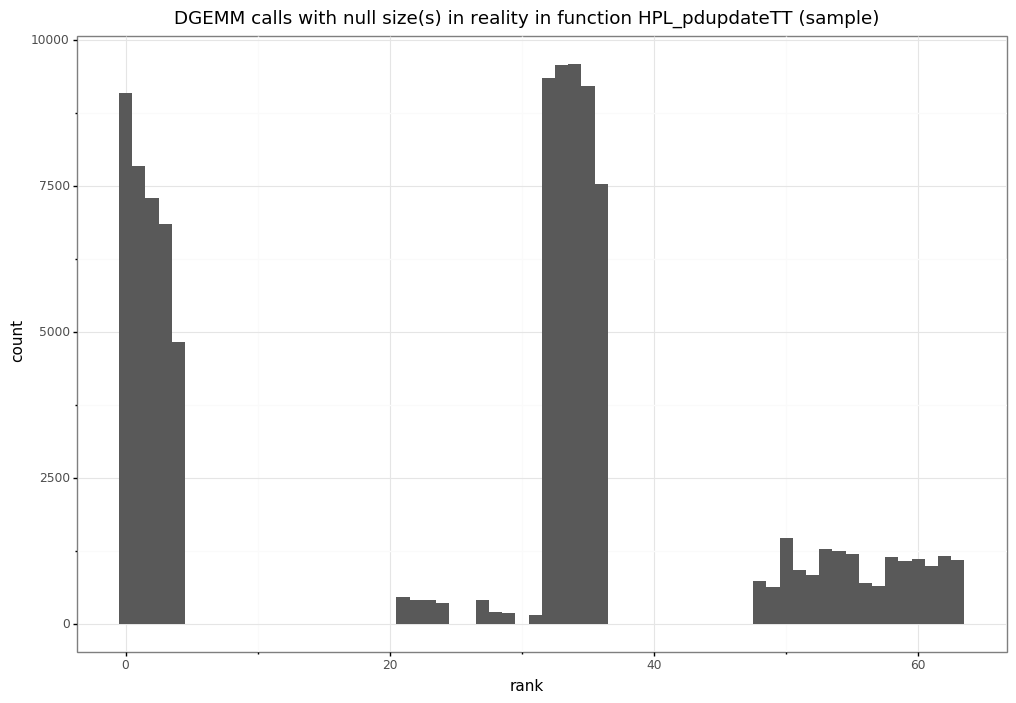

<ggplot: (8762283011304)>


In [20]:
for mode in tmp['mode'].unique():
    tmp_mode = tmp[(tmp['mode'] == mode)]
    try:
        tmp_mode = tmp_mode.sample(n=100000)
        sampled = True
    except ValueError:
        sampled = False
    print(ggplot(tmp_mode)
        + aes(x='rank')
        + geom_histogram(bins=64)
        + theme_bw()
        + ggtitle(f'DGEMM calls with null size(s) in {mode} in function HPL_pdupdateTT {"(sample)" if sampled else ""}')
    )

## Work in-balance

In [21]:
non_null_dgemm = non_null_traces_croped[non_null_traces_croped['function'] == 'dgemm'].copy()
non_null_dgemm['mnk'] = non_null_dgemm['m'] * non_null_dgemm['n'] * non_null_dgemm['k']

grouped = non_null_dgemm.groupby(['rank', 'mode'])[['duration', 'mnk']].sum().reset_index()
grouped['gflops'] = 2*grouped['mnk'] / grouped['duration'] * 1e-9
grouped.head()

,rank,mode,duration,mnk,gflops
0,0,reality,7.829978,9.873240e+10,25.219073
1,0,simgrid,7.182285,9.873240e+10,27.493312
2,1,reality,7.852714,1.003677e+11,25.562544
3,1,simgrid,7.225222,1.003677e+11,27.782585
4,2,reality,7.780957,1.020008e+11,26.218070


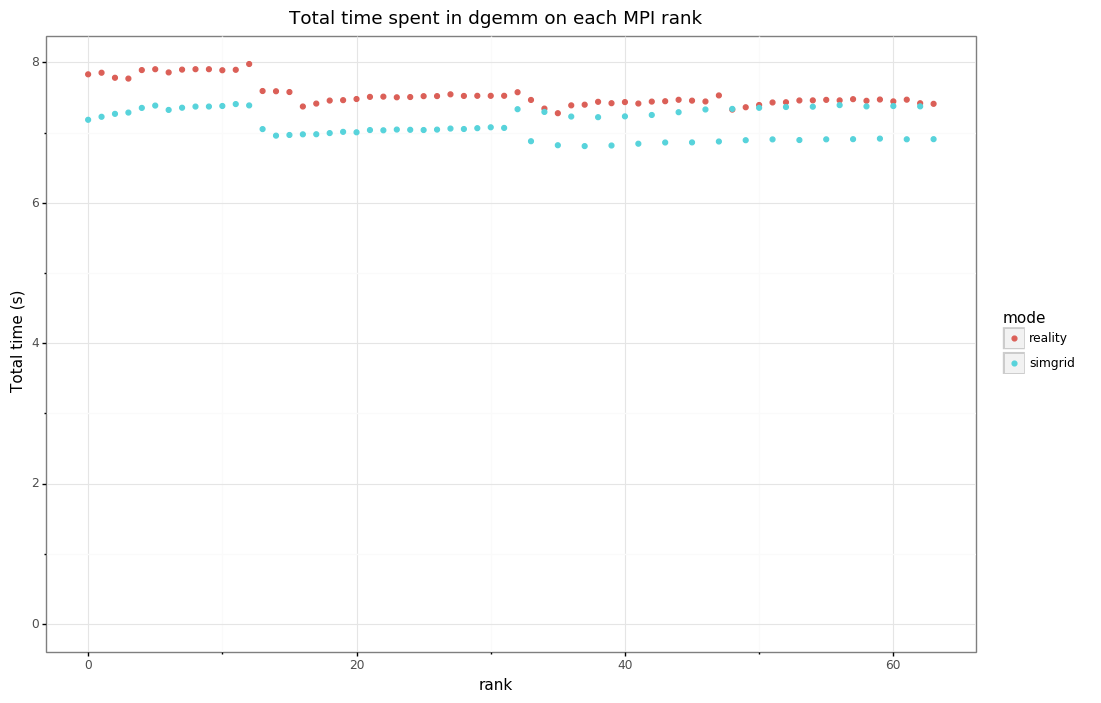

<ggplot: (-9223363274571742148)>

In [22]:
plot = ggplot(grouped) + aes(x='rank', y='duration', color='mode') + geom_point()
plot = plot + theme_bw() + ggtitle('Total time spent in dgemm on each MPI rank') + ylab('Total time (s)') + expand_limits(y=0)
plot

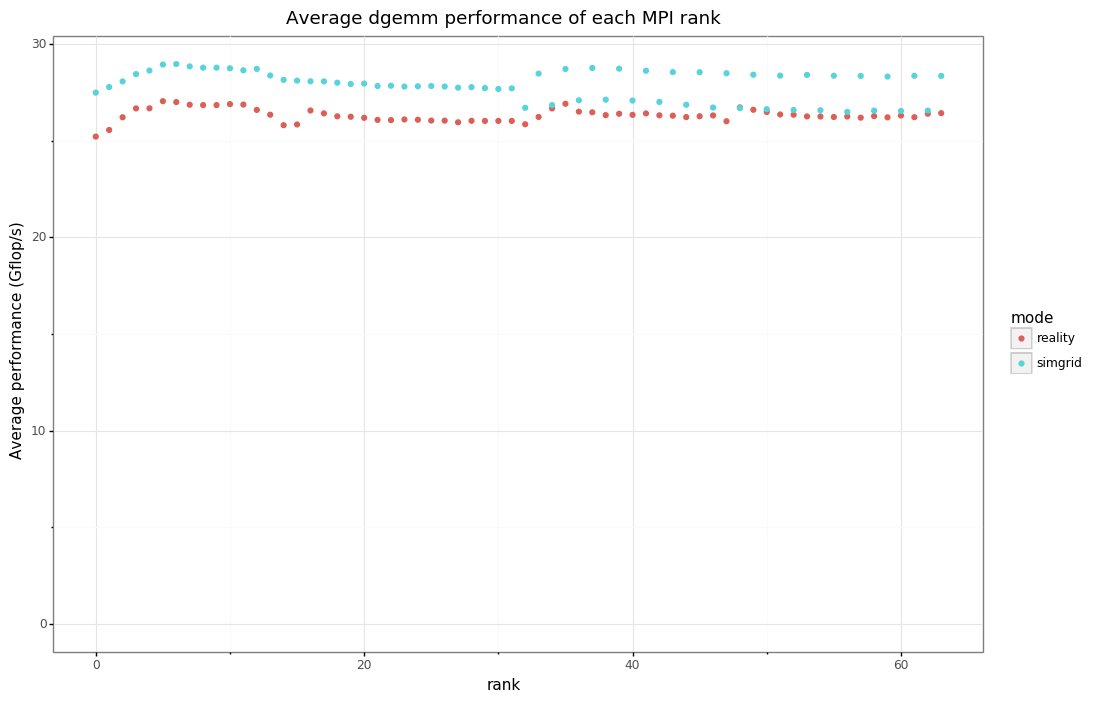

<ggplot: (8762283036175)>

In [23]:
plot = ggplot(grouped) + aes(x='rank', y='gflops', color='mode') + geom_point() + expand_limits(y=0)
plot = plot + theme_bw() + ggtitle('Average dgemm performance of each MPI rank') + ylab('Average performance (Gflop/s)')
plot

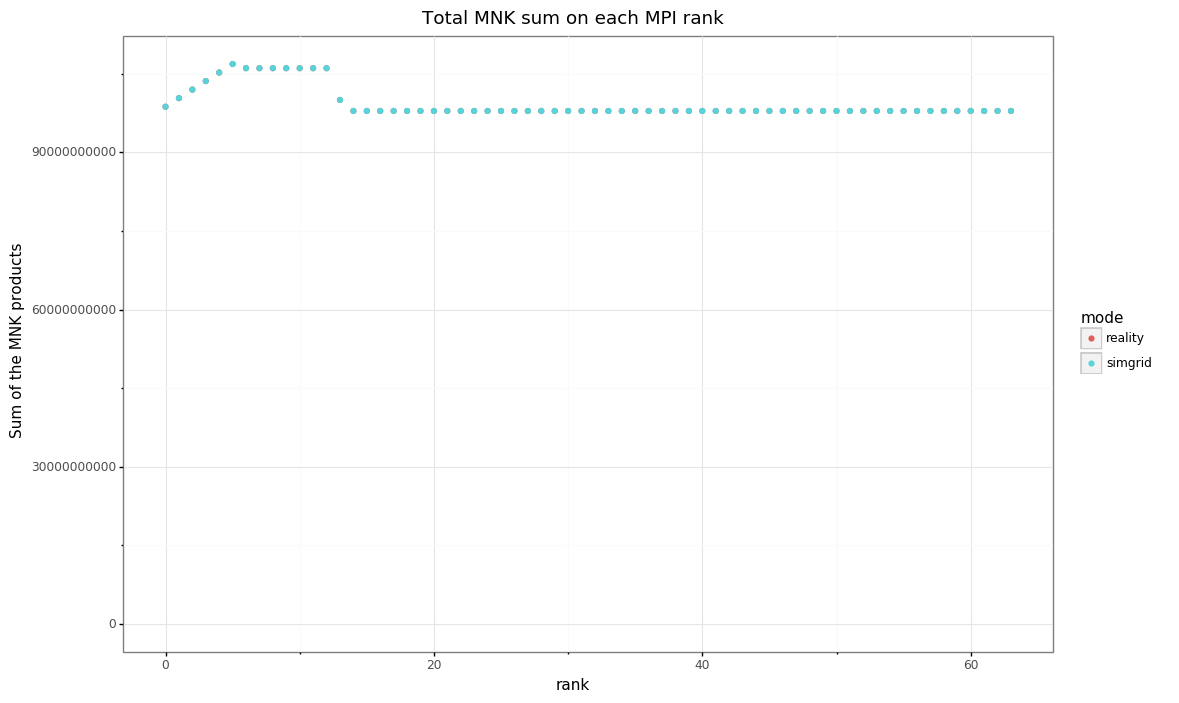

<ggplot: (8762283609513)>

In [24]:
plot = ggplot(grouped) + aes(x='rank', y='mnk', color='mode') + geom_point()
plot = plot + theme_bw() + ggtitle('Total MNK sum on each MPI rank') + ylab('Sum of the MNK products') + expand_limits(y=0)
plot